# Task 2 (Unsupervised Learning) - Characterizing Donors and Donation Type

In this task you should **use unsupervised learning algorithms and try to characterize donors (people who really did a donation) and their donation type**. You can use:
* **Association rule mining** to find **associations between the features and the target Donation/DonationTYPE**.
* **Clustering algorithms to find similar groups of donors**. Is it possible to find groups of donors with the same/similar DonationTYPE?
* **Be creative and define your own unsupervised analysis!** What would it be interesting to find out ?

## Unsupervised Learning: Clustering

To perform the clustering task we considered applying either K-means or Hierarchical Clustering. The main difference between these two methods lies in the way the clusters are chosen. K-means attempts to group the data in the number of clusters we define. Hierarchical clustering informs, pairwise, which two objects are most similar. In practical terms the two can be differentiated on the basis of scalability and flexibility. K-means is scalable but not appropriate for flexible data.  It is mostly efficient on numeric data.
Hierarchical Clustering is flexible but inefficient on large datasets, since it has to make several merge/split decisions, rendering it slower than K-means. Therefore, we chose to use K-means to find similar groups of donors. It should also be noticed that dendrograms produced by Hierarchical Clusters for big datasets are not be perceivable. If we had chosen it, we would not have been able to spot which point the item was split into different categories. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cluster
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import silhouette_score

## Preprocessing Data for Clustering

In [2]:
df_clean = pd.read_csv('donors_dataset_clean.csv') 
df_clean.head()

,TARGET_B,TARGET_D,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,SES,CLUSTER_CODE,INCOME_GROUP,MOR_HIT_RATE,MEDIAN_HOME_VALUE,...,LIFETIME_GIFT_RANGE_BIN,LAST_GIFT_AMT_BIN,CARD_PROM_12_BIN,NUMBER_PROM_12_BIN,MONTHS_SINCE_LAST_GIFT_BIN,MONTHS_SINCE_FIRST_GIFT_BIN,FILE_CARD_GIFT_BIN,INCOME_GROUP_BIN,RECENCY_STATUS_96NK_e,DONATION_TYPE
0,1.0,10.0,137.0,79.000000,0.0,2.0,45.0,7.0,0.0,334.0,...,"(15.0, 30.0]","(15.0, 30.0]","(3.0, 9.0]","(20.0, 30.0]","(-0.1, 8.0]","(120.0, 260.0]","(10.0, 20.0]","(6.4, 8.337]",4.0,D
1,0.0,0.0,113.0,75.000000,0.0,1.0,11.0,5.0,0.0,2388.0,...,"(15.0, 30.0]","(15.0, 30.0]","(9.0, 14.0]","(30.0, 64.0]","(-0.1, 8.0]","(80.0, 120.0]","(10.0, 20.0]","(4.4, 5.4]",4.0,NaN
2,0.0,0.0,92.0,62.695162,0.0,2.0,4.0,6.0,0.0,1688.0,...,"(-0.1, 15.0]","(-0.1, 15.0]","(9.0, 14.0]","(30.0, 64.0]","(-0.1, 8.0]","(80.0, 120.0]","(10.0, 20.0]","(5.4, 6.4]",0.0,NaN
3,0.0,0.0,101.0,74.000000,0.0,2.0,49.0,2.0,8.0,514.0,...,"(15.0, 30.0]","(15.0, 30.0]","(3.0, 9.0]","(10.0, 20.0]","(16.0, 24.0]","(80.0, 120.0]","(-0.1, 10.0]","(1.4, 2.4]",0.0,NaN
4,0.0,0.0,101.0,63.000000,0.0,3.0,8.0,3.0,0.0,452.0,...,"(-0.1, 15.0]","(-0.1, 15.0]","(3.0, 9.0]","(10.0, 20.0]","(16.0, 24.0]","(80.0, 120.0]","(-0.1, 10.0]","(2.4, 3.4]",0.0,NaN


In this task we will need the same subset as in Task 1.2. Thus, we will not considering the columns: TARGET_B, TARGET_D and binned data.

In [3]:
categorical_columns = ['DONOR_AGE_BIN', 'MONTHS_SINCE_ORIGIN_BIN', 'INCOME_GROUP_BIN','MOR_HIT_RATE_BIN', 'MEDIAN_HOME_VALUE_BIN', 
                       'MEDIAN_HOUSEHOLD_INCOME_BIN', 'PCT_OWNER_OCCUPIED_BIN', 'PER_CAPITA_INCOME_BIN', 'PCT_ATTRIBUTE1_BIN',
                      'PCT_ATTRIBUTE2_BIN', 'PCT_ATTRIBUTE3_BIN', 'PCT_ATTRIBUTE4_BIN', 'RECENT_RESPONSE_PROP_BIN',
                      'RECENT_AVG_GIFT_AMT_BIN', 'RECENT_CARD_RESPONSE_PROP_BIN', 'RECENT_AVG_CARD_GIFT_AMT_BIN',
                      'RECENT_RESPONSE_COUNT_BIN', 'RECENT_CARD_RESPONSE_COUNT_BIN', 'MONTHS_SINCE_LAST_PROM_RESP_BIN',
                      'LIFETIME_CARD_PROM_BIN', 'LIFETIME_PROM_BIN', 'LIFETIME_GIFT_AMOUNT_BIN','LIFETIME_GIFT_COUNT_BIN',
                      'LIFETIME_AVG_GIFT_AMT_BIN', 'LIFETIME_GIFT_RANGE_BIN', 'LAST_GIFT_AMT_BIN', 'CARD_PROM_12_BIN',
                      'NUMBER_PROM_12_BIN', 'MONTHS_SINCE_LAST_GIFT_BIN', 'MONTHS_SINCE_FIRST_GIFT_BIN', 'FILE_CARD_GIFT_BIN']

In [4]:
# In this subset, we will only consider donors (TARGET_B == 1 or DONATION_TYPE == NaN)
df_clean.drop(df_clean[df_clean['DONATION_TYPE'].isnull()].index, inplace=True)
df_clean.drop(columns=['TARGET_B','TARGET_D'], inplace=True)
df_clean.drop(columns = categorical_columns, inplace=True)
df_clean.head()

,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,SES,CLUSTER_CODE,INCOME_GROUP,MOR_HIT_RATE,MEDIAN_HOME_VALUE,MEDIAN_HOUSEHOLD_INCOME,PCT_OWNER_OCCUPIED,...,CARD_PROM_12,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT,FILE_CARD_GIFT,URBANICITY_e,DONOR_GENDER_e,OVERLAY_SOURCE_e,RECENCY_STATUS_96NK_e,DONATION_TYPE
0,137.0,79.000000,0.0,2.0,45.0,7.000000,0.0,334.0,212.0,72.0,...,7.0,21.0,7.0,122.0,12.0,1.0,1.0,3.0,4.0,D
6,89.0,79.000000,0.0,2.0,28.0,1.000000,0.0,1004.0,189.0,95.0,...,9.0,24.0,9.0,91.0,8.0,0.0,0.0,3.0,0.0,E
8,101.0,63.000000,0.0,2.0,43.0,4.000000,0.0,399.0,307.0,86.0,...,11.0,27.0,9.0,91.0,13.0,1.0,0.0,0.0,4.0,C
13,137.0,62.472055,0.0,2.0,43.0,3.346812,0.0,475.0,227.0,70.0,...,9.0,22.0,22.0,129.0,14.0,1.0,0.0,2.0,4.0,E
14,77.0,81.000000,0.0,2.0,45.0,4.000000,24.0,530.0,236.0,81.0,...,11.0,29.0,6.0,89.0,7.0,1.0,1.0,0.0,0.0,D


In [5]:
# Encode the categorical data - donation type 
ord_enc = OrdinalEncoder()
df_clean["DONATION_TYPE"] = ord_enc.fit_transform(df_clean[["DONATION_TYPE"]])

In [6]:
# Data preparation: from dataframe to arrays
nc = df_clean.shape[1]
matrix = df_clean.values 
X = matrix [:, 0:nc-1] 
y = matrix [:, nc-1]          
features = df_clean.columns.values[0:nc-1] 
target = df_clean.columns.values[nc-1] 

###  Finding Groups

#### With Principal Components Analysis (PCA)

In order to find the number of features which hold more information about the dataset, we are performing a PCA analysis on each variable on our dataset (n_variables=41) and computing the variances for each feature. The features are ordered by their variance and the tendency is towards zero. Therefore, the features with highest variance should be included in the analysis. 

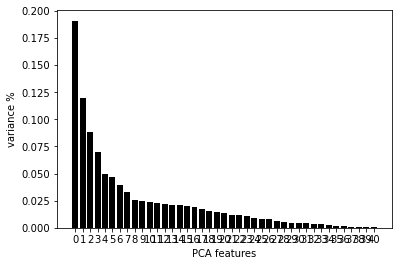

In [7]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(X)
# Create a PCA instance: pca
pca = PCA(n_components=41)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

As we can see PC1 (feature 0) accounts for the highest percentage of the total variation. Due to the distribution of the percentages of the variation, it is very hard to discerne which variables account for most of the variation in the data. Therefore, when the search space is plotted into a 2D graph, the clusters will appear together.

##### 2 Components 

Text(0, 0.5, 'PCA 2')

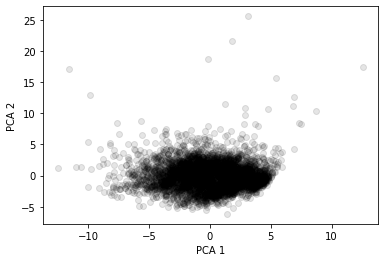

In [8]:
# Data visualization with 2 PCA components
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

As expected, the scatter plot for the first two features of the PCA analysis is a dense mass of data. There are no evident groups which indicates a poor clustering result _a priori_ .

###### Elbow Plot 

One strategy to infer the number of clusters to be used in a K-Means analysis is the Elbow Plot. It plots the inertia as a funciton of the clusters. As the K-means algorithm aims to choose centroids that minimise the inertia value, the ideal number of clusters is when the first low value of inertia is reached. As it happens, in a good dataset with proper groups this value emerges suddenly, which makes the plot look like an elbow.

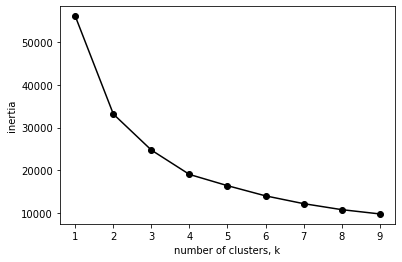

In [9]:
# Number of clusters to test
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Each time we add a new cluster, the total variation within each cluster is smaller than before. When we get to one point per cluster, the variation =0.
In our case, we do not have an 'elbow' as expected from the PCA plot above. Therefore, the number of clusters will not have a great impact on the analysis, as the performances will always be overfitting.

###### K-Means

/anaconda3/envs/pgds/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/anaconda3/envs/pgds/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/anaconda3/envs/pgds/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/anaconda3/envs/pgds/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


Text(1026.3913043478262, 0.5, 'PC2')

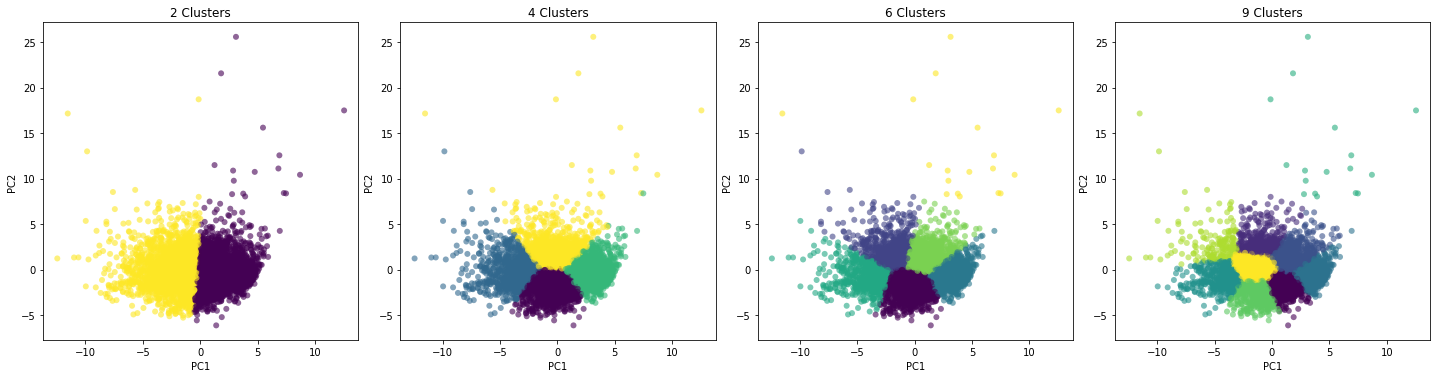

In [10]:
# PCA
pca = PCA(n_components=2).fit(X_std)
data2D = pca.transform(X_std)

# Kmeans for 2, 4, 6 and 9 clusters
km2 = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=3, random_state=0)
km4 = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=3, random_state=0)
km6 = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=3, random_state=0)
km9 = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=3, random_state=0)
km2 = km2.fit(data2D)
km4 = km4.fit(data2D)
km6 = km6.fit(data2D)
km9 = km9.fit(data2D)
labels2 = km2.predict(data2D)
labels4 = km4.predict(data2D)
labels6 = km6.predict(data2D)
labels9 = km9.predict(data2D)

# Plots

f, axes = plt.subplots(1, 4, figsize=(20, 5))
f.tight_layout()

# 2 Clusters
axes[0].scatter(data2D[:, 0], data2D[:, 1], c=km2.labels_, edgecolor='', alpha=0.6)
axes[0].set_title('2 Clusters')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')


# 4 Clusters
axes[1].scatter(data2D[:, 0], data2D[:, 1], c=km4.labels_, edgecolor='', alpha=0.6)
axes[1].set_title('4 Clusters')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

# 6 Clusters
axes[2].scatter(data2D[:, 0], data2D[:, 1], c=km6.labels_, edgecolor='', alpha=0.6)
axes[2].set_title('6 Clusters')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')

# 9 Clusters
axes[3].scatter(data2D[:, 0], data2D[:, 1], c=km9.labels_, edgecolor='', alpha=0.6)
axes[3].set_title('9 Clusters')
axes[3].set_xlabel('PC1')
axes[3].set_ylabel('PC2')


###### Model Evaluation 

Homogeneity Score 2 Clusters:  0.056487172371880744
V Measure Score 2 Clusters:  0.0766927096682634 

Homogeneity Score 4 Clusters:  0.14154216964100827
V Measure Score 4 Clusters:  0.14559301879554037 

Homogeneity Score 6 Clusters:  0.1626881639095854
V Measure Score 6 Clusters:  0.1543607025203254 

Homogeneity Score 9 Clusters:  0.1851276395606536
V Measure Score 9 Clusters:  0.1549198094874549 



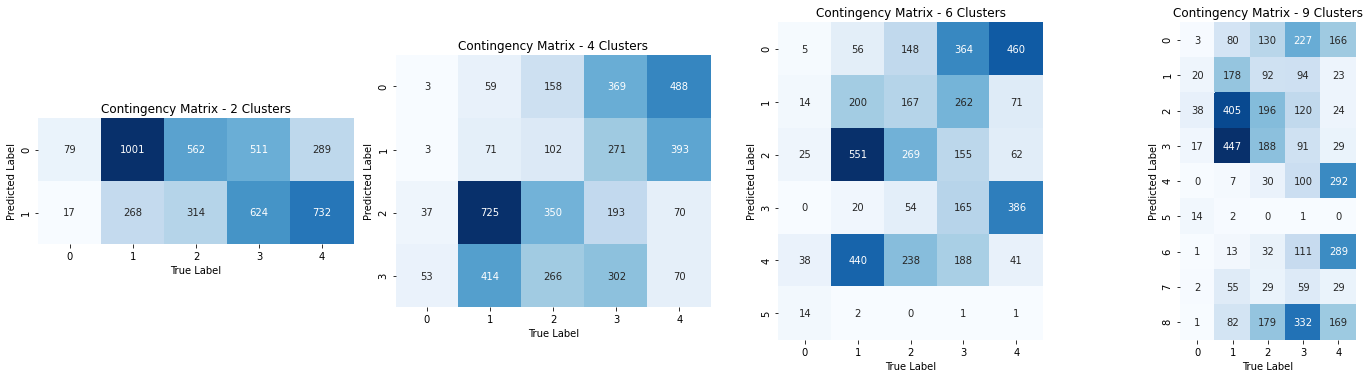

In [11]:
# Scores and confusion matrix

labels = [labels2, labels4, labels6, labels9]
names = ['2 Clusters', '4 Clusters', '6 Clusters', '9 Clusters']

f, axes = plt.subplots(1, 4, figsize=(20, 5))
f.tight_layout()

for label, name, i in zip(labels, names, range(len(names))):
    
    # Scores
    print('Homogeneity Score {}: '.format(name), homogeneity_score(y, label))
    print('V Measure Score {}: '.format(name), v_measure_score(y, label), '\n')

    # Contingency Matrix
    cont_m = cluster.contingency_matrix(y, label)

    sns.heatmap(cont_m.T, square=True, annot=True, fmt='d', cbar=False,cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('True Label')
    axes[i].set_ylabel('Predicted Label');
    axes[i].set_title('Contingency Matrix - {}'.format(name))

#### 7 Components 

###### K-Means 

In [12]:
# PCA
pca = PCA(n_components=7).fit(X_std)
data2D = pca.transform(X_std)

# Kmeans for 2, 4, 6 and 9 clusters
km2 = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=3, random_state=0)
km4 = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=3, random_state=0)
km6 = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=3, random_state=0)
km9 = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=3, random_state=0)
km2 = km2.fit(data2D)
km4 = km4.fit(data2D)
km6 = km6.fit(data2D)
km9 = km9.fit(data2D)
labels2 = km2.predict(data2D)
labels4 = km4.predict(data2D)
labels6 = km6.predict(data2D)
labels9 = km9.predict(data2D)

###### Model Evaluation 

Homogeneity Score 2 Clusters:  0.054986721259634004
V Measure Score 2 Clusters:  0.0746137161261042 

Homogeneity Score 4 Clusters:  0.08590588961959622
V Measure Score 4 Clusters:  0.08914254028240559 

Homogeneity Score 6 Clusters:  0.13957019441673504
V Measure Score 6 Clusters:  0.1285901332844211 

Homogeneity Score 9 Clusters:  0.1349388376809281
V Measure Score 9 Clusters:  0.11331837212946817 



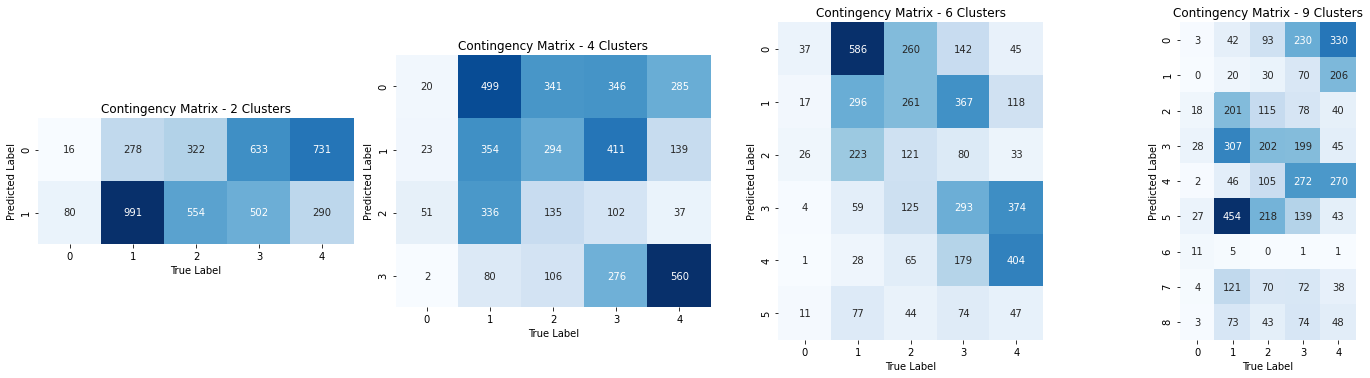

In [13]:
# Scores and confusion matrix

labels = [labels2, labels4, labels6, labels9]
names = ['2 Clusters', '4 Clusters', '6 Clusters', '9 Clusters']

f, axes = plt.subplots(1, 4, figsize=(20, 5))
f.tight_layout()

for label, name, i in zip(labels, names, range(len(names))):
    
    # Scores
    print('Homogeneity Score {}: '.format(name), homogeneity_score(y, label))
    print('V Measure Score {}: '.format(name), v_measure_score(y, label), '\n')

    # Contingency Matrix
    cont_m = cluster.contingency_matrix(y, label)

    sns.heatmap(cont_m.T, square=True, annot=True, fmt='d', cbar=False,cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('True Label')
    axes[i].set_ylabel('Predicted Label');
    axes[i].set_title('Contingency Matrix - {}'.format(name))

#### Without Principal Components Analysis (PCA)

###### K-Means 

In [14]:
# Kmeans for 2, 4, 6 and 9 clusters
km2 = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=3, random_state=0)
km4 = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=3, random_state=0)
km6 = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=3, random_state=0)
km9 = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=3, random_state=0)
km2 = km2.fit(X_std)
km4 = km4.fit(X_std)
km6 = km6.fit(X_std)
km9 = km9.fit(X_std)
labels2 = km2.predict(X_std)
labels4 = km4.predict(X_std)
labels6 = km6.predict(X_std)
labels9 = km9.predict(X_std)

###### Model Evaluation 

Homogeneity Score 2 Clusters:  0.05250461291201649
V Measure Score 2 Clusters:  0.07124114485578971 

Homogeneity Score 4 Clusters:  0.1284711035101387
V Measure Score 4 Clusters:  0.13233581135184963 

Homogeneity Score 6 Clusters:  0.1376121182661689
V Measure Score 6 Clusters:  0.1271962548315639 

Homogeneity Score 9 Clusters:  0.14527306409934315
V Measure Score 9 Clusters:  0.1265306506138936 



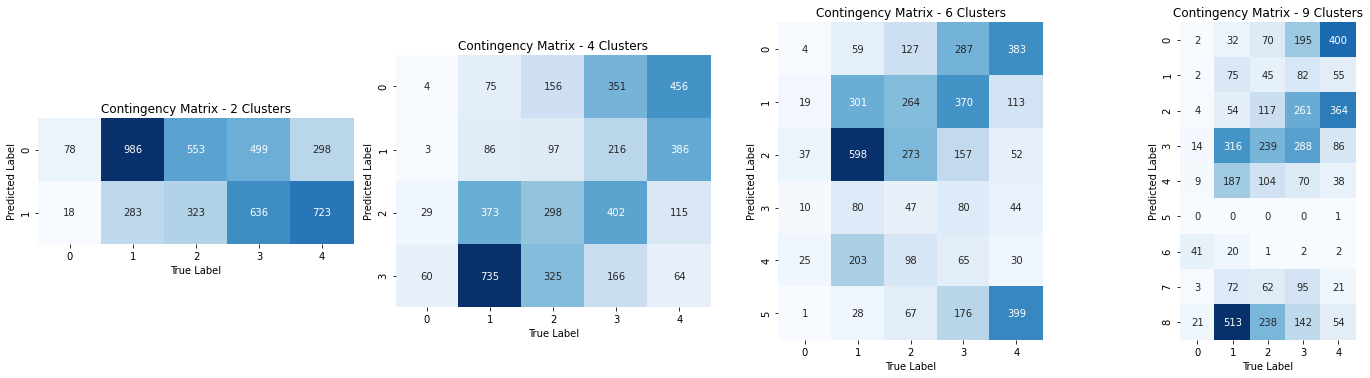

In [15]:
# Scores and confusion matrix

labels = [labels2, labels4, labels6, labels9]
names = ['2 Clusters', '4 Clusters', '6 Clusters', '9 Clusters']

f, axes = plt.subplots(1, 4, figsize=(20, 5))
f.tight_layout()

for label, name, i in zip(labels, names, range(len(names))):
    
    # Scores
    print('Homogeneity Score {}: '.format(name), homogeneity_score(y, label))
    print('V Measure Score {}: '.format(name), v_measure_score(y, label), '\n')

    # Contingency Matrix
    cont_m = cluster.contingency_matrix(y, label)

    sns.heatmap(cont_m.T, square=True, annot=True, fmt='d', cbar=False,cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('True Label')
    axes[i].set_ylabel('Predicted Label');
    axes[i].set_title('Contingency Matrix - {}'.format(name))

## Results and Discussion

The PCA variation plot hinted at the scores we achieved. Each of the features in the dataset holds little variance when compared to the other features, and there are many of them. This made it terribly difficult for the model to separate our features into clusters. This was also confirmed by the 2-Component PCA plot. It was also evident when we divided our dataset into 2, 4 and 6 clusters for k-means. We observed this dense mass, composed by the superposition of data points in the plotted space, be divided into artificial boundaries since it was impossible to accurately divide the dataset into meaningful clusters. 
Increasing the number of clusters might have increased the score, but its influence was irrelevant with a dataset that has these many variables, with so little variance between them. On the other hand, usually PCA is an efficient way to augment k-means clustering, through noise reduction. K-means seeks to represent all 𝑛 data vectors via small number of cluster centroids. This is done to minimize the mean-squared reconstruction error. PCA seeks to represent all 𝑛 data vectors as linear combinations of a small number of eigenvectors. Since the 2 first Eigenvector have the largest variance, in our case, splitting on these vectores (which resemble cluster membership) would mean maximizing between cluster variance. By maximizing between cluster variance, we minimize within-cluster variance, too. But since our datapoints appear to densely concentrate in the same area, K-means with PCA or without PCA had pretty much the same scores, as it was impossible to maximize the variation between clusters.